In [205]:
# Setup:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.base import clone
import pandas as pd
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset, random_split
from torchmetrics.classification import BinaryAUROC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [3]:
test_set = pd.read_csv('data/test.csv')
training_set = pd.read_csv('data/train.csv')

In [4]:
means = None
stdevs = None

# Define preprocessing transform
def conversion_transform(df, is_test = False):
    # drop text columns
    new_df = df.drop(columns=['track_href', 'uri', 'type', 'analysis_url'])

    if is_test == True:
        new_df = new_df.drop(columns=['ID'])

    # Handle dates 
    date_column = new_df["track_album_release_date"].astype(str)

    parsed = pd.to_datetime(date_column, format='%Y-%m-%d', errors='coerce')
    new_df["year"] = parsed.dt.year
    new_df["month"] = parsed.dt.month
    new_df["day"] = parsed.dt.day

    # For year-only dates, extract year and default month/day to 1
    year_only_mask = new_df["year"].isna()
    new_df.loc[year_only_mask, "year"] = pd.to_numeric(date_column[year_only_mask], errors='coerce')
    new_df.loc[year_only_mask, "month"] = np.nan
    new_df.loc[year_only_mask, "day"] = np.nan

    new_df = new_df.drop(columns='track_album_release_date')

    if is_test == False:
        # Binarization of the output
        column_names = list(new_df.columns.values)
        column_names.append(column_names.pop(column_names.index('Popularity_Type')))
        new_df = new_df[column_names]

        new_df['Popularity_Type'] = new_df['Popularity_Type'].map({'High': 1, 'Low': 0})

    return new_df

def normalization_transform(df, is_test = False):
    # normalize data
    new_df = df.copy()
    if is_test == False:
        new_df.iloc[:, :-1] -= means
        new_df.iloc[:, :-1] /= stdevs
    else: 
        new_df = new_df[feature_columns]
        new_df -= means
        new_df /= stdevs
    # replace all the nan values with zero
    new_df = new_df.fillna(0)
    return new_df

def preprocessing(df, is_test= False):
    new_df = conversion_transform(df, is_test)
    new_df = normalization_transform(new_df, is_test)
    return new_df

# compute normalization mean and stdev
filtered_training = conversion_transform(training_set)
means = np.nanmean(filtered_training.iloc[:, :-1], axis=0)
stdevs = np.nanstd(filtered_training.iloc[:, :-1], axis=0)
feature_columns = list(filtered_training.columns[:-1])

filtered_training = preprocessing(training_set)

# Save IDs
test_IDs = test_set['ID'].values

In [5]:
# Music Dataloader
class MusicDataset(Dataset):
    """Music dataset."""

    def __init__(self, dataset, is_test, transform=None, to_remove=None):
        """
        Arguments:
            dataset: Pandas dataframe
            transform: Transformation to data
        """

        data = dataset
        if transform:
            data = transform(dataset, is_test)
        if to_remove:
            data = data.drop(columns=to_remove)
        self.labels = list(data.columns)

        # If it's the test set, there are no labels 
        if is_test:
            self.X = torch.tensor( data.values, dtype=torch.float32)
            self.y = None

        else:
        # example: last column is label, rest are features
            self.X = torch.tensor(
                data.iloc[:, :-1].values,
                dtype=torch.float32
            )
            self.y = torch.tensor(
                data.iloc[:, -1].values,
                dtype=torch.long
            )

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
    def __getlabels__(self):
        return self.labels

In [6]:
num_features = filtered_training.shape[1]-1
neuralnet = nn.Sequential(
    nn.Linear(num_features, 256),
    nn.GELU(),
    nn.Dropout(0.25),

    nn.Linear(256, 128),
    nn.GELU(),
    nn.Dropout(0.25),

    nn.Linear(128, 32),
    nn.GELU(),
    nn.Dropout(0.25),

    nn.Linear(32,1),
    nn.Sigmoid()
)

In [7]:
optimizer = torch.optim.Adam(neuralnet.parameters(), lr=5*1e-4)
loss_fn = nn.BCELoss()

In [8]:
# split and load the data 
def split_data(dataset):
    train_size = int(len(dataset)*0.8)
    test_size = len(dataset) - train_size
    split_sizes = [train_size, test_size]
    train_dataset, valid_dataset = random_split(dataset, split_sizes, generator=torch.Generator().manual_seed(42))
    return train_dataset, valid_dataset

In [9]:
dataset = MusicDataset(training_set, is_test=False, transform=preprocessing)
train_dataset, valid_dataset = split_data(dataset)
training_data_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_data_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

In [10]:
def evaluate(model, dataset):
    # Switch to the evaluation mode: 
    model.eval()
    auroc_metric = BinaryAUROC(thresholds=None)

    # Compute the predictions and compare to the true labels
    pred = model(dataset.dataset.X[dataset.indices])
    auroc_metric.update(pred, dataset.dataset.y[dataset.indices])
    acc = auroc_metric.compute().numpy().item()
    model.train() 
    
    return acc

In [11]:
neuralnet.train()
train_error = []
test_error = []

for epoch in range(20):
    for batch_idx, (data, target) in enumerate(training_data_loader):
        # Erase accumulated gradients
        optimizer.zero_grad()

        # Forward pass
        output = neuralnet(data)

        # Calculate loss
        loss = loss_fn(output.squeeze(), target.float())

        # Backward pass
        loss.backward()
        
        # Weight update
        optimizer.step()

    # Track loss each epoch
    print('Train Epoch: %d  Loss: %.4f' % (epoch + 1,  loss.item()))
    train_error.append(evaluate(neuralnet, train_dataset))
    print('Accuracy on the training set is', evaluate(neuralnet, train_dataset))
    test_error.append(evaluate(neuralnet, valid_dataset))
    print('Accuracy on the testing set is', evaluate(neuralnet, valid_dataset))

Train Epoch: 1  Loss: 0.7309
Accuracy on the training set is 0.7686705589294434
Accuracy on the testing set is 0.7646705508232117
Train Epoch: 2  Loss: 0.4953
Accuracy on the training set is 0.7869820594787598
Accuracy on the testing set is 0.7838901877403259
Train Epoch: 3  Loss: 0.5005
Accuracy on the training set is 0.7921167016029358
Accuracy on the testing set is 0.7901632189750671
Train Epoch: 4  Loss: 0.5938
Accuracy on the training set is 0.7992556095123291
Accuracy on the testing set is 0.7961545586585999
Train Epoch: 5  Loss: 0.6111
Accuracy on the training set is 0.8053050637245178
Accuracy on the testing set is 0.8003218173980713
Train Epoch: 6  Loss: 0.4445
Accuracy on the training set is 0.8098213076591492
Accuracy on the testing set is 0.8033546209335327
Train Epoch: 7  Loss: 0.4757
Accuracy on the training set is 0.8145673274993896
Accuracy on the testing set is 0.8022719621658325
Train Epoch: 8  Loss: 0.4769
Accuracy on the training set is 0.8179498910903931
Accuracy o

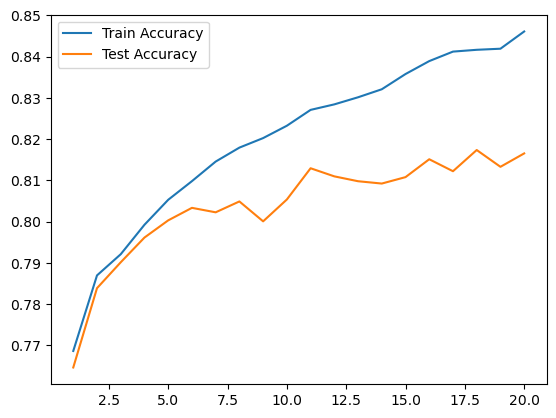

In [12]:
epochs = np.linspace(1,20, 20)
plt.plot(epochs, train_error, label = 'Train Accuracy')
plt.plot(epochs, test_error, label = 'Test Accuracy')
plt.legend()

In [13]:
# Now let's produce the output on the test_set 
torch_test = MusicDataset(test_set, is_test=True, transform=preprocessing)

In [14]:
### Now let's train an XGboost and/or Random Forest Model

dataset = MusicDataset(training_set, is_test= False, transform=preprocessing)
X_np = dataset.X.numpy()
y_np = dataset.y.numpy()

torch_test = MusicDataset(test_set, is_test=True, transform=preprocessing)

X_test_np = torch_test.X.numpy()

# X_train, X_test, y_train, y_test = train_test_split(X_np, y_np, test_size= 0.15, random_state=37)
XGboost = XGBClassifier(objective='binary:logistic', n_estimators = 100, max_depth = 6)
XGboost.fit(X_np, y_np)
y_pred = XGboost.predict_proba(X_test_np)[:,1]

In [15]:
# rfc_clf = RandomForestClassifier(criterion='gini', n_estimators=100, max_depth=150)
# rfc_clf.fit(X_train, y_train)
# y_pred = rfc_clf.predict(X_test)
# acc = accuracy_score(y_pred, y_test)
# print(acc)

# Feature Selection

In [344]:
# Divide up data
dataset = MusicDataset(training_set, is_test=False, transform=preprocessing)
train_dataset, valid_dataset = split_data(dataset)
X = dataset.X.squeeze()
y = dataset.y.squeeze()
X_train = train_dataset.dataset.X[train_dataset.indices].squeeze()
y_train = train_dataset.dataset.y[train_dataset.indices].squeeze()
X_valid = valid_dataset.dataset.X[valid_dataset.indices].squeeze()
y_valid = valid_dataset.dataset.y[valid_dataset.indices].squeeze()

In [345]:
# Get features list
features = dataset.__getlabels__()[:-1]

In [346]:
# Train XGBoost on model and identify most important features
model = XGBClassifier(objective='binary:logistic', n_estimators = 100, max_depth = 3)
model.fit(X_train, y_train)

# Define table with features and feature importances
df = pd.DataFrame(
    {
        'feature': features,
        'feature_importance': model.feature_importances_
    }
)
df.sort_values(by='feature_importance', ascending=False)

,feature,feature_importance
6,instrumentalness,0.323686
13,year,0.102268
10,loudness,0.065940
11,acousticness,0.064749
4,energy,0.049612
2,danceability,0.049183
3,duration_ms,0.046299
7,valence,0.044653
15,day,0.043445
14,month,0.042253


In [347]:
# Remove irrelevant features
bad_features = list(df[df['feature_importance'] < 0.02]['feature']) # 0.04 best
dataset = MusicDataset(training_set, is_test= False, transform=preprocessing,
                       to_remove=bad_features)
train_dataset, valid_dataset = split_data(dataset)
torch_test = MusicDataset(test_set, is_test=True, transform=preprocessing,
                          to_remove=bad_features)

In [348]:
# Divide up data
X = dataset.X.squeeze()
y = dataset.y.squeeze()
X_train = train_dataset.dataset.X[train_dataset.indices].squeeze()
y_train = train_dataset.dataset.y[train_dataset.indices].squeeze()
X_valid = valid_dataset.dataset.X[valid_dataset.indices].squeeze()
y_valid = valid_dataset.dataset.y[valid_dataset.indices].squeeze()

# Ensemble selection

In [349]:
def ensemble_selection(models, valid_pred, y_valid, max_size, resampling=False):
    """
    Performs ensemble selection given a list of models trained on test to
    maximize AUC

    Args:
        models: array of models trained
        valid_pred: predictions for validation set
        y_valid: true values for validation set
    
    Returns:
        Ensemble of models that maximizes AUC on the validation set
    """
    ensemble = []
    remaining = list(models)

    best_auc = 0
    while len(ensemble) < max_size:
        best_model = None

        for m in remaining:
            candidate = ensemble + [m]
            preds = np.mean([valid_pred[x] for x in candidate], axis=0)
            auc = roc_auc_score(y_valid, preds)

            if auc >= best_auc:
                best_auc = auc
                best_model = m

        if best_model is None:
            break

        ensemble.append(best_model)
        if not resampling:
            remaining.remove(best_model)
        print(best_auc)

    return ensemble

In [350]:
# List of parameters
nn_params_list = [
    dict(hidden_units=64,  dropout=0.5,  lr=1e-3),
    dict(hidden_units=128, dropout=0.3,  lr=5e-4),
    dict(hidden_units=256, dropout=0.2,  lr=3e-4),
    dict(hidden_units=32, dropout=0.1,  lr=1e-4),
]

xgboost_params_list = [ 
    dict(max_depth=6, learning_rate=0.1, subsample=0.5, colsample_bytree=0.6), 
    dict(max_depth=5, learning_rate=0.05, subsample=0.4, colsample_bytree=0.5), 
    dict(max_depth=4, learning_rate=0.03, subsample=0.6, colsample_bytree=0.4),
    dict(max_depth=3, learning_rate=0.02, subsample=0.4, colsample_bytree=0.3),
]

random_forest_params_list = [
    dict(max_depth=8, max_features=0.5),
    dict(max_depth=12, max_features="sqrt"),
    dict(max_depth=None, max_features=0.3),
]

light_gbm_params_list = [
    dict(num_leaves=31, learning_rate=0.05, colsample_bytree=0.4),
    dict(num_leaves=63, learning_rate=0.03, colsample_bytree=0.3)
]

logistic_params_list = [
    dict(C=10**n) for n in range(-2, 3)
]

# Training models
def train_nn(hidden_units, dropout, lr):
    # Define neural network
    neuralnet = nn.Sequential(
        nn.Linear(num_features, hidden_units),
        nn.ReLU(),
        nn.Dropout(dropout),

        nn.Linear(hidden_units, hidden_units // 2),
        nn.ReLU(),
        nn.Dropout(dropout),

        nn.Linear(hidden_units // 2, 1),
        nn.Sigmoid()
    )

    # Define optimizer and loss function
    optimizer = torch.optim.NAdam(neuralnet.parameters(), lr=lr)
    loss_fn = nn.BCELoss()

    # Training model
    neuralnet.train()
    for _ in range(20):
        for _, (data, target) in enumerate(training_data_loader):
            # Erase accumulated gradients
            optimizer.zero_grad()

            # Forward pass
            output = neuralnet(data)

            # Calculate loss
            loss = loss_fn(output.squeeze(), target.float())

            # Backward pass
            loss.backward()
            
            # Weight update
            optimizer.step()

    # turn off training
    neuralnet.eval()
    return neuralnet

def train_xgboost(max_depth, learning_rate, subsample, colsample_bytree):
    model = XGBClassifier(objective='binary:logistic', 
                          n_estimators = 800, max_depth = max_depth,
                          learning_rate = learning_rate, subsample = subsample,
                          colsample_bytree = colsample_bytree, eval_metric='auc')
    model.fit(X_train.numpy(), y_train.numpy())
    return model

def train_random_forest(max_depth, max_features):
    model = RandomForestClassifier(criterion='entropy', n_estimators=100,
                          max_depth=max_depth, max_features=max_features)
    model.fit(X_train.numpy(), y_train.numpy())
    return model

def train_light_gbm(num_leaves, learning_rate, colsample_bytree):
    model = LGBMClassifier(num_leaves=num_leaves, learning_rate=learning_rate,
                           colsample_bytree=colsample_bytree, verbosity=-1)
    model.fit(X_train.numpy(), y_train.numpy())
    return model

def train_logistic(C):
    model = LogisticRegression(C=C, penalty='l2')
    model.fit(X_train.numpy(), y_train.numpy())
    return model
    

In [351]:
# # Train all nn models and evaluate on validation
# nn_models = []
# for param in nn_params_list:
#     nn_models += [train_nn(param['hidden_units'], param['dropout'], param['lr'])]

# with torch.no_grad():
#     nn_valid_pred = { 
#         model: model(X_valid).numpy().flatten()
#         for model in nn_models 
#     }

In [352]:
# Train XGBoost and evaluate on validation
xgboost_models = []
for param in xgboost_params_list:
    xgboost_models += [train_xgboost(param['max_depth'], 
                                     param['learning_rate'],
                                     param['subsample'],
                                     param['colsample_bytree'])]

xgboost_valid_pred = { 
    model: model.predict_proba(X_valid)[:, 1]
    for model in xgboost_models 
}

In [353]:
# Train Random Forest and evaluate on validation
random_forest_models = []
for param in random_forest_params_list:
    random_forest_models += [train_random_forest(param['max_depth'], 
                                                 param['max_features'])]

random_forest_valid_pred = { 
    model: model.predict_proba(X_valid)[:, 1]
    for model in random_forest_models 
}

In [354]:
import warnings

# LGBM complains when there are no labels
warnings.filterwarnings(
    action='ignore', 
    category=UserWarning, 
    module='sklearn.utils.validation'
)

# Train Random Forest and evaluate on validation
lgbm_models = []
for param in light_gbm_params_list:
    lgbm_models += [train_light_gbm(param['num_leaves'], 
                                    param['learning_rate'],
                                    param['colsample_bytree'])]

lgbm_valid_pred = { 
    model: model.predict_proba(X_valid)[:, 1]
    for model in lgbm_models 
}

In [355]:
# Train Logistic Regression and evaluate on validation
logistic_models = []
for param in logistic_params_list:
    logistic_models += [train_logistic(param['C'])]

logistic_valid_pred = { 
    model: model.predict_proba(X_valid)[:, 1]
    for model in logistic_models 
}

In [356]:
# Combine everything
models = xgboost_models + random_forest_models + logistic_models
valid_pred = xgboost_valid_pred | random_forest_valid_pred | logistic_valid_pred
print(f'Ensemble draws from {len(models)} models')

Ensemble draws from 12 models


In [357]:
# Run ensemble method
ensemble = ensemble_selection(models, valid_pred, y_valid.numpy(), max_size=len(models) * 2, resampling=False)

0.8553039403241832
0.8578176209755157
0.8578250359626878
0.8588038142694012


In [358]:
# Check types of models contained
for model in ensemble:
    print(type(model))

<class 'xgboost.sklearn.XGBClassifier'>
<class 'sklearn.ensemble._forest.RandomForestClassifier'>
<class 'sklearn.ensemble._forest.RandomForestClassifier'>
<class 'xgboost.sklearn.XGBClassifier'>


# Cross-Validation

In [359]:
def cross_validation(n_splits, ensemble):
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    scores = []

    for train_idx, val_idx in cv.split(X, y):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        preds = []

        for model in ensemble:
            model.fit(X_train, y_train)
            preds.append(model.predict_proba(X_val)[:, 1])

        ensemble_pred = np.mean(preds, axis=0)
        scores.append(roc_auc_score(y_val, ensemble_pred))
    return scores

In [360]:
scores = cross_validation(n_splits=10, ensemble=ensemble)
print(f'The mean AUC is {np.mean(scores)} +/- {np.std(scores)/np.sqrt(10)}')

The mean AUC is 0.8431956303326997 +/- 0.006684471113322926


# Stacking

In [380]:
# Define stack
estimators = [
    (f"xgb{i}", clone(model)) for i, model in enumerate(xgboost_models + lgbm_models + random_forest_models + logistic_models)
]
for i, (j, model) in enumerate(estimators):
    model.set_params(random_state=i)
stack = StackingClassifier(
    estimators=estimators,
    final_estimator=clone(random_forest_models[0]),
    stack_method="predict_proba",
    cv=5,
    n_jobs=-1
)

In [381]:
# Cross-validation
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(
    stack,
    X,
    y,
    cv=outer_cv,
    scoring="roc_auc"
)

In [382]:
print(f'The mean AUC is {np.mean(scores)} +/- {np.std(scores)/np.sqrt(5)}')

The mean AUC is 0.8382454431272034 +/- 0.007615493967840164


In [383]:
# Train on entire dataset and evaluate
stack.fit(X, y)
y_test = stack.predict_proba(torch_test.X)[:, 1]
y_test

array([3.84144310e-01, 2.64782179e-01, 6.55449790e-01, 7.17308130e-01,
       2.37762195e-01, 5.09988851e-02, 3.29638626e-01, 2.71852998e-01,
       9.79597089e-01, 4.23331765e-01, 2.67500157e-01, 3.33263073e-01,
       3.86586679e-01, 2.24389319e-01, 4.60708964e-01, 6.45436943e-01,
       2.43024512e-01, 4.81145571e-03, 8.53362703e-03, 2.44703066e-01,
       2.29714269e-01, 1.47718050e-02, 2.40894747e-03, 1.85345577e-03,
       9.03066517e-02, 1.42172635e-01, 4.11802846e-01, 5.03120255e-01,
       1.25562830e-02, 1.37947749e-01, 2.38115909e-01, 3.91118306e-01,
       1.15224602e-02, 1.56725744e-02, 2.09481671e-01, 1.62496415e-01,
       8.40542218e-02, 4.56320478e-02, 3.13063643e-01, 2.33265389e-01,
       3.49001141e-01, 1.17674710e-02, 5.70497185e-01, 3.66027988e-01,
       2.43385202e-01, 6.80491274e-01, 9.71666667e-01, 6.25077360e-04,
       3.08923843e-01, 1.31205582e-01, 7.54063725e-01, 4.65049041e-01,
       2.05538716e-01, 8.45575838e-01, 1.09174788e-03, 3.67564427e-03,
      

In [384]:
# Save to file
submission6 = pd.DataFrame({
    'ID': test_IDs,
    'Popularity_Type': y_test
})
submission6.to_csv('submission6.csv', index=False)

In [131]:
# Evaluate on test
def evaluate_ensemble(ensemble, X):
    test_pred = np.zeros(X.numpy().shape[0])
    for model in ensemble:
        test_pred += model.predict_proba(X)[:, 1]
    return test_pred / len(ensemble)

# Retrain models on ALL data
[model.fit(X, y) for model in ensemble]

y_test = evaluate_ensemble(ensemble, torch_test.X)
y_test

array([0.6241602 , 0.31531761, 0.42883595, 0.74198484, 0.40010006,
       0.20997628, 0.34673764, 0.27185327, 0.84339606, 0.42373441,
       0.52109343, 0.30227309, 0.45598833, 0.24507934, 0.52147631,
       0.5319435 , 0.25587205, 0.05299661, 0.13628264, 0.35320772,
       0.36557552, 0.07459991, 0.00968622, 0.01357848, 0.25752431,
       0.24320674, 0.38278266, 0.41076695, 0.13211361, 0.16396658,
       0.3111333 , 0.439991  , 0.05049661, 0.04381962, 0.1558414 ,
       0.20288745, 0.13534647, 0.16050358, 0.32791178, 0.38448624,
       0.29626414, 0.01927071, 0.441386  , 0.63048486, 0.01122412,
       0.56029852, 0.84926253, 0.00993213, 0.40772233, 0.24045596,
       0.72081532, 0.42914388, 0.29507833, 0.81584144, 0.02220808,
       0.0493761 , 0.2274584 , 0.36749598, 0.2467408 , 0.45839664,
       0.29549265, 0.64973633, 0.01249516, 0.29529083, 0.01021647,
       0.29658876, 0.60783898, 0.01054008, 0.07683464, 0.32126685,
       0.00954176, 0.14531647, 0.36748052, 0.12386769, 0.52048

In [132]:
# Save to file
submission6 = pd.DataFrame({
    'ID': test_IDs,
    'Popularity_Type': y_test
})
submission6.to_csv('submission6.csv', index=False)

In [ ]:
models[0].feature_importances_

array([0.07881532, 0.07930765, 0.08593754, 0.18899614, 0.08309434,
       0.10443603, 0.08074354, 0.14301103, 0.07610199, 0.07955642],
      dtype=float32)

In [ ]:
training_set

,time_signature,speechiness,danceability,duration_ms,energy,track_href,mode,uri,type,track_album_release_date,analysis_url,instrumentalness,valence,key,tempo,loudness,acousticness,liveness,Popularity_Type
0,4.0,0.2040,0.882,140733.0,0.764,https://api.spotify.com/v1/tracks/7iabz12vAuVQ...,1.0,spotify:track:7iabz12vAuVQYyekFIWJxD,audio_features,2024-05-23,https://api.spotify.com/v1/audio-analysis/7iab...,0.000000,0.8860,11.0,140.113,-5.241,0.359000,0.1190,High
1,4.0,0.1590,0.779,246960.0,0.640,https://api.spotify.com/v1/tracks/4TsmezEQVSZN...,1.0,spotify:track:4TsmezEQVSZNNPv5RJ65Ov,audio_features,2005-08-29,https://api.spotify.com/v1/audio-analysis/4Tsm...,0.000766,0.4990,7.0,99.017,-8.415,0.000155,0.1010,High
2,4.0,0.2230,0.770,189707.0,0.597,https://api.spotify.com/v1/tracks/1AtFSBJibfaq...,1.0,spotify:track:1AtFSBJibfaqfiOByQCwZ5,audio_features,2024-06-21,https://api.spotify.com/v1/audio-analysis/1AtF...,0.000000,0.8750,1.0,170.022,-4.901,0.530000,0.2390,High
3,5.0,0.3210,0.573,172296.0,0.693,https://api.spotify.com/v1/tracks/18Crh1Nd55lR...,1.0,spotify:track:18Crh1Nd55lRX4MVoJegO1,audio_features,2024-11-08,https://api.spotify.com/v1/audio-analysis/18Cr...,0.004240,0.8370,6.0,150.850,-6.220,0.609000,0.1960,Low
4,4.0,0.0315,0.714,274488.0,0.720,https://api.spotify.com/v1/tracks/42Xxh6RlXeZU...,1.0,spotify:track:42Xxh6RlXeZUNtNfbJ6A3D,audio_features,2020-12-24,https://api.spotify.com/v1/audio-analysis/42Xx...,0.000000,0.6960,6.0,113.015,-6.751,0.092200,0.0742,Low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3859,4.0,0.0778,0.687,165753.0,0.818,https://api.spotify.com/v1/tracks/7MIhUdNJtaOn...,1.0,spotify:track:7MIhUdNJtaOnDmC5nBC1fb,audio_features,2022-06-17,https://api.spotify.com/v1/audio-analysis/7MIh...,0.000000,0.8860,0.0,125.952,-4.221,0.011200,0.2480,High
3860,4.0,0.3690,0.611,175059.0,0.710,https://api.spotify.com/v1/tracks/2UsdXWoJI0dD...,1.0,spotify:track:2UsdXWoJI0dDlMAtxeBBg7,audio_features,2024-06-18,https://api.spotify.com/v1/audio-analysis/2Usd...,0.000000,0.5520,7.0,85.931,-7.933,0.457000,0.1230,Low
3861,4.0,0.0313,0.550,222073.0,0.412,https://api.spotify.com/v1/tracks/2wbb3Czcii7S...,1.0,spotify:track:2wbb3Czcii7Sv0x5na95w2,audio_features,2022-12-17,https://api.spotify.com/v1/audio-analysis/2wbb...,0.000000,0.0986,11.0,120.897,-8.414,0.366000,0.2400,Low
3862,4.0,0.0476,0.671,248440.0,0.712,https://api.spotify.com/v1/tracks/2fuCquhmrzHp...,1.0,spotify:track:2fuCquhmrzHpu5xcA1ci9x,audio_features,1982-05-03,https://api.spotify.com/v1/audio-analysis/2fuC...,0.000000,0.4620,2.0,113.805,-7.815,0.429000,0.1030,High
